<a href="https://colab.research.google.com/github/hamisB/machine-learning/blob/master/Complaigns_MultiLabel_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## DATA IMPORT
---



In [1]:
# import librairies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas_profiling as pp
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Get the data
data = pd.io.gbq.read_gbq(
'''
SELECT
  Product,
  Consumer_complaint_narrative
FROM
  `bigquery-public-data.cfpb_complaints.complaint_database`
WHERE
  Consumer_complaint_narrative IS NOT NULL
LIMIT
  100000
'''
, project_id="t-water-211708", dialect='standard')

dataset = data.copy()
dataset.head()

,Product,Consumer_complaint_narrative
0,Prepaid card,The Western Union Netspend card is only XXXX o...
1,Prepaid card,I received a XXXX XXXX rebate card in the form...
2,Prepaid card,Without receiving any notification that my acc...
3,Prepaid card,I received a Citi Visa Debit card with a balan...
4,Prepaid card,In the process of making a purchase over the i...


In [0]:
# Create a list of top 10 productType
product_list = list(dataset.Product.value_counts().reset_index()['index'][0:10])

# Function to agregate the top 10 productType
def productType(elem):
  if elem in product_list:
    info = elem
  else :
    info = "Other"
  return info  

In [0]:
# Apply function to product to create the column productType
dataset['productType'] = dataset['Product'].apply(lambda x : productType(x))

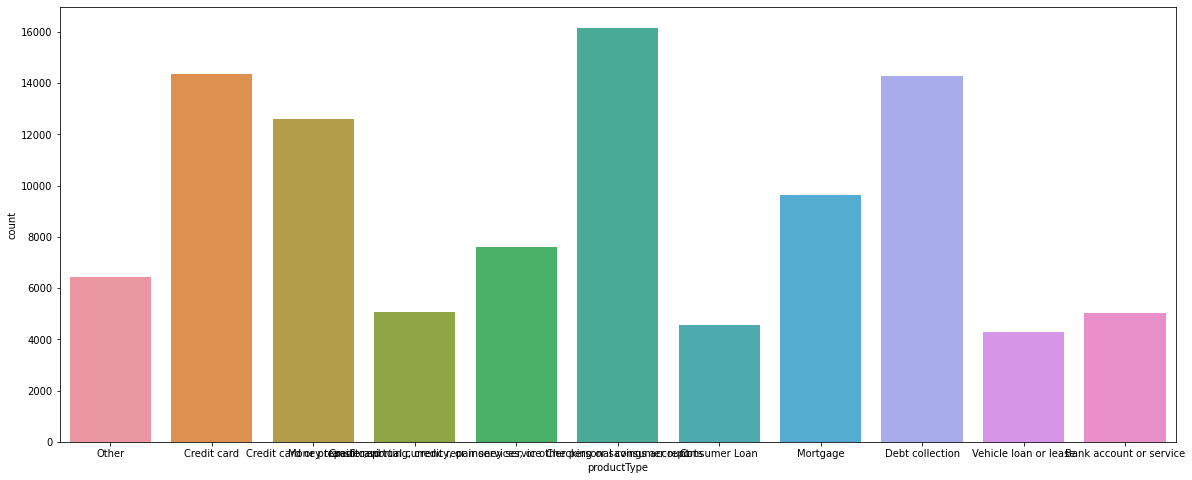

In [5]:
plt.figure(figsize=(20,8))
sns.countplot(x='productType', data=dataset)


## TEXT EDA
---



In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# Words to delete 
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
STEMMER = nltk.stem.SnowballStemmer('english')
# Cleaning function
def clean_text(text):
    text_lower = text.lower()
    text_clean = re.sub('[^a-z_]', ' ', text_lower)
    tokens = [w for w in text_clean.split() if (len(w)>2) and (w not in STOPWORDS)]
    tokens_stem = [ STEMMER.stem(token) for token in tokens]
    return tokens_stem

In [8]:
# Encoding the label
encod = LabelEncoder()
info = encod.fit_transform(dataset['productType'])
label = pd.DataFrame(info, index=dataset.index, columns=['Label'])
dataset_ml = dataset.merge(label, left_index=True, right_index=True)
dataset_ml.head()

,Product,Consumer_complaint_narrative,productType,Label
0,Prepaid card,The Western Union Netspend card is only XXXX o...,Other,9
1,Prepaid card,I received a XXXX XXXX rebate card in the form...,Other,9
2,Prepaid card,Without receiving any notification that my acc...,Other,9
3,Prepaid card,I received a Citi Visa Debit card with a balan...,Other,9
4,Prepaid card,In the process of making a purchase over the i...,Other,9


In [9]:
# Product type label
dataset_ml[['productType', 'Label']].drop_duplicates()

,productType,Label
0,Other,9
39,Credit card,3
2208,Credit card or prepaid card,4
2365,"Money transfer, virtual currency, or money ser...",7
2376,"Credit reporting, credit repair services, or o...",5
9697,Checking or savings account,1
20193,Consumer Loan,2
22111,Mortgage,8
23600,Debt collection,6
59607,Vehicle loan or lease,10


In [0]:
# Vectorizer 
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=15000,
                                 use_idf=True, tokenizer=clean_text,
                                 ngram_range=(1,2))

X = tfidf_vectorizer.fit_transform(dataset_ml.Consumer_complaint_narrative).toarray()
Y = dataset_ml.Label

In [0]:
# Training , Testing dataset 
x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.4 , stratify=Y, random_state=42)

In [12]:
from sklearn.metrics import accuracy_score , precision_score, recall_score , confusion_matrix , classification_report
clf = MultinomialNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(f"Acc Score : {accuracy_score(y_pred, y_test)}\n==============================")
print(f"Preci Score : {precision_score(y_pred, y_test, average='micro')}\n==============================")
print(f"Recall Score : {recall_score(y_pred, y_test, average='micro')}\n==============================")

Acc Score : 0.709675
Preci Score : 0.709675
Recall Score : 0.709675


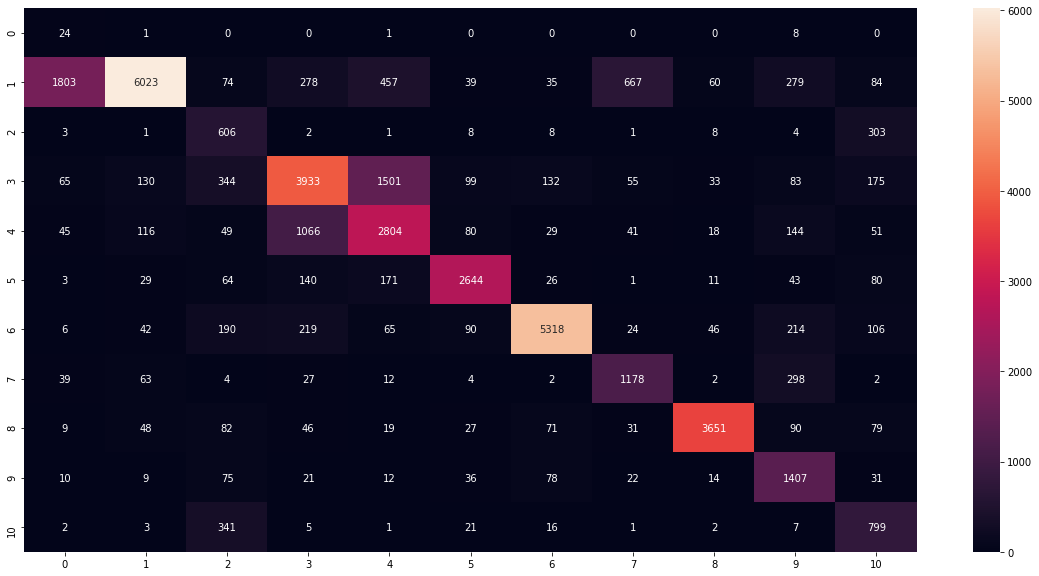

In [17]:
plt.figure(figsize=(20,10))
sns.heatmap(data=pd.DataFrame(confusion_matrix(y_pred, y_test)), annot=True ,fmt='.6g')

In [18]:
y_test.value_counts()

1     6465
3     5737
6     5715
4     5044
8     3845
5     3048
9     2577
7     2021
0     2009
2     1829
10    1710
Name: Label, dtype: int64

In [19]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.01      0.71      0.02        34
           1       0.93      0.61      0.74      9799
           2       0.33      0.64      0.44       945
           3       0.69      0.60      0.64      6550
           4       0.56      0.63      0.59      4443
           5       0.87      0.82      0.84      3212
           6       0.93      0.84      0.88      6320
           7       0.58      0.72      0.65      1631
           8       0.95      0.88      0.91      4153
           9       0.55      0.82      0.66      1715
          10       0.47      0.67      0.55      1198

    accuracy                           0.71     40000
   macro avg       0.62      0.72      0.63     40000
weighted avg       0.79      0.71      0.74     40000



In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
lo_reg = LogisticRegression(random_state=42)
tree_de = DecisionTreeClassifier(random_state=42)
rdf = RandomForestClassifier(random_state=42)

In [0]:
lo_reg.fit(x_train, y_train)
y_pred_logreg = lo_reg.predict(x_test)
print(accuracy_score(y_pred,y_test))
print(classification_report(y_pred_logreg , y_test))